<a href="https://colab.research.google.com/github/nberns/AirfoilDesign/blob/main/AirfoilDesign_presentation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors: Nils Berns, Violetta Germann
Version date: Jan 26, 2021
Project name: Airfoil Design
Done as the final project of the course "Machine Learning with Tensorflow" at opencampus.sh

# Design of Airfoils

Airfoils usually are designed using complex differential equations. Programs such as XFoil use iterative numerical methods to compute the flow parameters for a given airfoil profile or vice versa.

The idea is to feed a NN with a set of airfoil profiles (2D outlines) and flow parameters for the end of learning how to design the airfoils outline for a desired lift under given flow conditions.

To preprocess the training data, a set of almost 1600 coordinate files for labelled airfoils is loaded:

In [1]:
# download archive to google colab, into current directory
!wget https://m-selig.ae.illinois.edu/ads/archives/coord_seligFmt.tar.gz

--2021-01-28 15:13:58--  https://m-selig.ae.illinois.edu/ads/archives/coord_seligFmt.tar.gz
Resolving m-selig.ae.illinois.edu (m-selig.ae.illinois.edu)... 18.220.149.166
Connecting to m-selig.ae.illinois.edu (m-selig.ae.illinois.edu)|18.220.149.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 632733 (618K) [application/x-gzip]
Saving to: ‘coord_seligFmt.tar.gz’

coord_seligFmt.tar. 100%[===================>] 617.90K   700KB/s    in 0.9s    

2021-01-28 15:14:01 (700 KB/s) - ‘coord_seligFmt.tar.gz’ saved [632733/632733]



In [2]:
import os

# extract archive, folder "coor_seligFmt" is created
!sudo tar -xvf coord_seligFmt.tar.gz
os.remove('coord_seligFmt.tar.gz') # remove the archive
# largest database on airfoils freely available
# using it with xfoil however requires reformatting the coordinate files, as the data points are not listed as expected by XFOIL
# see https://www.youtube.com/watch?v=hTq1C_oYmhY

coord_seligFmt/
coord_seligFmt/2032c.dat
coord_seligFmt/a18.dat
coord_seligFmt/a18sm.dat
coord_seligFmt/a63a108c.dat
coord_seligFmt/ag03.dat
coord_seligFmt/ag04.dat
coord_seligFmt/ag08.dat
coord_seligFmt/ag09.dat
coord_seligFmt/ag10.dat
coord_seligFmt/ag11.dat
coord_seligFmt/ag12.dat
coord_seligFmt/ag13.dat
coord_seligFmt/ag14.dat
coord_seligFmt/ag16.dat
coord_seligFmt/ag17.dat
coord_seligFmt/ag18.dat
coord_seligFmt/ag19.dat
coord_seligFmt/ag24.dat
coord_seligFmt/ag25.dat
coord_seligFmt/ag26.dat
coord_seligFmt/ag27.dat
coord_seligFmt/ag35.dat
coord_seligFmt/ag36.dat
coord_seligFmt/ag37.dat
coord_seligFmt/ag38.dat
coord_seligFmt/ag44ct02r.dat
coord_seligFmt/ag455ct02r.dat
coord_seligFmt/ag45c03.dat
coord_seligFmt/ag45ct02r.dat
coord_seligFmt/ag46c03.dat
coord_seligFmt/ag46ct02r.dat
coord_seligFmt/ag47c03.dat
coord_seligFmt/ag47ct02r.dat
coord_seligFmt/ah21-7.dat
coord_seligFmt/ah21-9.dat
coord_seligFmt/ah63k127.dat
coord_seligFmt/ah6407.dat
coord_seligFmt/ah7476.dat
coord_seligFmt/ah791

A Python-XFoil package is installed to generate the desired lift coefficients for the given airfoils. Later, these values will be part of the input variables for the NN.

In [3]:
import shutil

cwd = os.getcwd() # current working directory, hopefully where the folder with the coordinate files is located

# installing xfoil-python https://pypi.org/project/xfoil/
try:
  os.mkdir(cwd + '/xfoil-python/')
  os.chdir(cwd + '/xfoil-python/')
  ! git clone https://github.com/DARcorporation/xfoil-python.git
  os.chdir(cwd + '/xfoil-python/xfoil-python/')
  ! pip install .
  os.chdir(cwd)
  shutil.rmtree(cwd + '/xfoil-python/') # delete the folder xfoil-python and all its content after successfully installing the package
except OSError:
  os.chdir(cwd)
  pass

Cloning into 'xfoil-python'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 1125 (delta 38), reused 46 (delta 20), pack-reused 1056
Receiving objects: 100% (1125/1125), 4.80 MiB | 3.80 MiB/s, done.
Resolving deltas: 100% (642/642), done.
Processing /content/xfoil-python/xfoil-python
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for xfoil: filename=xfoil-1.1.1-cp36-cp36m-linux_x86_64.whl size=287549 sha256=3355c86eb42c9a24d6a7cd3148adaa3fedcb8505478d890167f40ec61903056f
  Stored in directory: /root/.cache/pip/wheels/ef/d0/94/f1ebacd181bd144eb56c6dc2ec57438a5ca8aa74078d514c8a
Successfully built xfoil


In [ ]:
# Alternatives to xfoil-python

# install XFOIL in Colab, the original tool, not required with any of the xfoil packages in python
# !sudo apt-get install xfoil
# http://www.joshtheengineer.com/2019/02/06/running-xfoil-from-python/

# functionality was not clear
# https://airfoildatabase.readthedocs.io/en/latest/index.html
# try:
#   os.mkdir('/content/AirfoilDatabase/')
#   %cd /content/AirfoilDatabase/
#   ! git clone https://github.com/usuaero/AirfoilDatabase
#   %cd /content/AirfoilDatabase/AirfoilDatabase/
#   ! pip install .
# except OSError:
#   pass
# %cd /content/

# works reliably only with vanilla python
# https://aeropy.readthedocs.io/en/latest/xfoil_module.html

In [4]:
import numpy as np
import tensorflow as tf
import csv
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import random
import pandas as pd
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier

# success check, no error means successfully installed xfoil-python
from xfoil.model import Airfoil
from xfoil import XFoil
xf = XFoil()

A set of flow parameters is set:
The angle of attack is varied in a range from -5 to 5 degrees.
The Reynolds number is a non-dimensional number which quantifies the state of a fluid flow, generally speaking whether it is laminar ("ordered") or turbulent. The Reynolds number is proportional to the relative wind speed and the characteristic length of the geometry, here the chord width (chord line). 

---


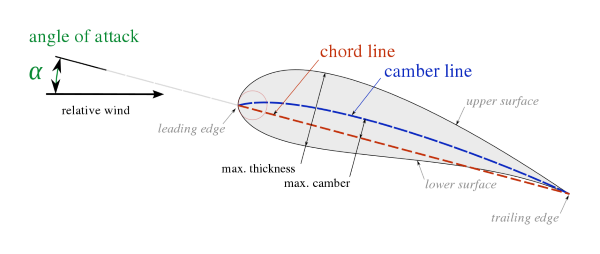

# Defining the Flow Parameters

In [5]:
# setting up the flow parameters

# Reynolds number
# 20 flow velocities/aircraft speeds between 72km/h and 540km/h in air at 10°C
# equidistant spacing on logscale
Re = np.logspace(np.log10(1.4e6), np.log10(1.05e7), 20)

# angle of attack
# between -5 and 5 degrees
alpha = np.arange(-5., 5.5, .5)

# Mach number
Ma = 0.0

# when using xfoil assume viscous flow

# Preprocessing the given coordinate files
The files are being cleared from unnecessary text oder odd datapoints and are put together to onedimensional vectors for input data purposes. The airfoil's names could serve as labels for a classification task.
The various datasets are ordered in a manner that they all represent the outline in the same fashion: TE-->LE (via upper outline)-->TE (via lower outline) (see picture above)

In [6]:
def read_coordinates(SOURCE):
    # function that returns all coordinates read from the files in the submitted directory
    # problems with the coordinate files:
    #   - the delimiter most of the time is ' ', somtimes '\t'
    #   - the headers mess up the number of columns
    #   - sometimes the header exceeds the first line
    #   - sometimes a second set of coordinates begins in the middle of the file, indicated by a second header, these second sets are skipped
    #   - sometimes values are wrapped in brakets
    #   - sometimes the value '0.0000' is replaced with a sequence of dots
    #   - in naca4412.dat the last but one value misses the decimal seperator, should equal 1.0000
    #   - sometimes the values are scaled with 100.0
    x1s = [] # x coordinates of all airfoils
    x2s = [] # y coordinates of all airfoils
    airfoil_names = []
    lengths = [] # number of coordinate pairs in each file
    for fname in os.listdir(SOURCE):
      if fname != 'naca1.dat': # exclude naca1, information/data is incomplete
        airfoil_names.append(fname[:-4])
        x1 = [] # x coordinates of one airfoil
        x2 = [] # y coordinates of one airfoil
        with open(SOURCE + fname, errors='ignore') as coordinate_file: # ignore errors due to encoding in the header
          counter = 0 # count the delimiter "\t", used as trigger
          for line in coordinate_file: # look for the delimiter in this file
            if '\t' in line:
              counter += 1
          if counter > 0: # choose the delimiter
            delimiter = '\t'
          else:
            delimiter = ' '
          coordinate_file.seek(0) # go back to the start of the file (byte 0)
          csv_reader = csv.reader(coordinate_file, delimiter=delimiter) # delimiter is blank space
          next(csv_reader) # skip header
          if fname == 's1020.dat':
            next(csv_reader) # skip second line also
          elif fname in ['nasasc2-0714.dat', 'e850.dat']:
            next(csv_reader) # skip second and
            next(csv_reader) # third line as well
          jump_to_eof = False # jump to end of file if another header is found in the file, skip the second dataset
          for row in csv_reader: # iterate through file row by row
            if jump_to_eof == True:
              pass
            else:
              counter1 = 0 # count the entries in a row
              for item in row:
                append_item = False
                try: # try to convert item's value to float, works only if it is a number
                  float(item)
                  item_valid = item
                  counter1 += 1
                  append_item = True
                except: # if the conversion did not work
                  if item == '': # skip items with empty string
                    append_item = False
                  elif item[0] not in ['-', '.', '(']: # skip items which do not begin as expected, skip the rest of the file (e.g. another header of a second coordinates set)
                    append_item = False
                    jump_to_eof = True
                  else:
                    append_item = True
                    counter1 += 1
                    if item in ['.......', '......']:
                      item_valid = '0.0000'
                    elif item[0] == '(': # some entries are numbers in brakets
                      item_valid = item[1:-1]
                if append_item == True:
                  if counter1 == 1:
                    x1.append(float(item_valid))
                  elif counter1 == 2:
                    x2.append(float(item_valid))
            if counter1 > 0 and len(x1) != len(x2): # if this row fed only one variable, remove this value
              if len(x2) > len(x1):
                del x2[-1]
              else:
                del x1[-1]
          if x1[-1] > 99. and x1[-2] < 10.:
            x1[-1] = 1.0000 # the value lacks the decimal seperator or has it at the wrong position
          elif x1[-1] == 100. and x1[-2] > 10.:
            x1 = [i/100. for i in x1] # coordinates are scaled by 100
            x2 = [i/100. for i in x2]

          # make required changes to identified airfoils which violated the expected order
          if fname == 'cap21c.dat': # this airfoil has two odd values, delete or overwrite
            del x1[-1] # the last point does not fit
            del x2[-1]
            x2[6] = 0.000650 # 0.000397 does not fit in

          if fname == 'e850.dat': # this airfoil goes from LE to TE to LE, therefore detect the TE and reverse the order before and after
            j = x1.index(1.0) # index of the TE, somewhere in the middle of the list
            x1[:j+1] = list(reversed(x1[:j+1]))
            x2[:j+1] = list(reversed(x2[:j+1]))

          x1s.append(x1)
          x2s.append(x2)
          lengths.append(len(x1))
          # file closes after with-block
    return x1s, x2s, lengths, airfoil_names
  
source = cwd + '/coord_seligFmt/'

x1s, x2s, lengths, airfoil_names = read_coordinates(source)

Text(0.5, 1.0, 'fx79w470a')

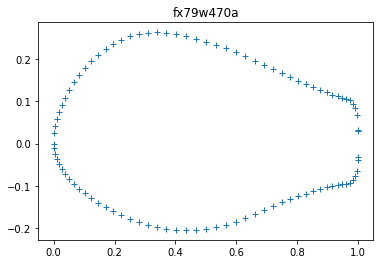

In [8]:
# plot single airfoil by name
i = airfoil_names.index('fx79w470a')
plt.figure()
plt.plot(x1s[i], x2s[i], '+')
plt.title(airfoil_names[i])

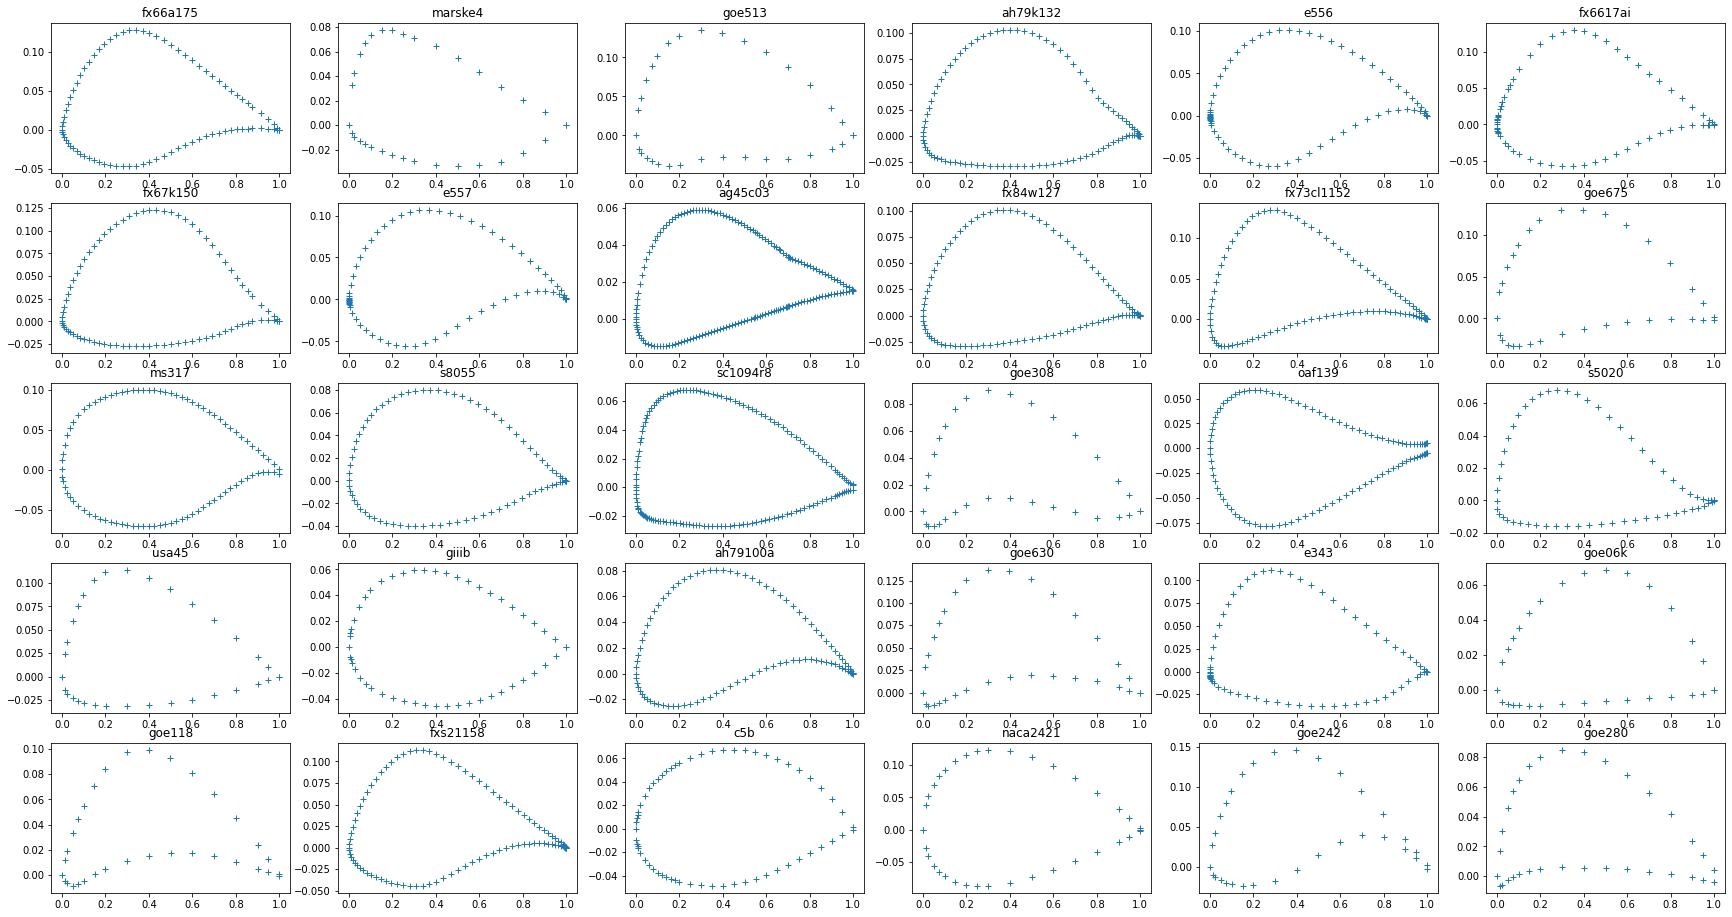

In [9]:
# plot shapes of multiple airfoils
for group in [0]: # , 1, 2, 3]: # 0 for first 30, 1 for second 30, 2 for third 30, 3 for fourth 30 airfoils, and so forth
  Is = range(0, 5)
  Js = range(0, 6)
  shift = group*len(Is)*len(Js)
  fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(30, 16))
  for i in Is:
    for j in Js:
      axs[i,j].plot(x1s[shift+i*len(Js)+j], x2s[shift+i*len(Js)+j], '+')
      axs[i,j].set(title=airfoil_names[shift+i*len(Js)+j]) # write the name of the airfoil in the subplot's title

In [10]:
# assure order of coordinates is right

def verify_coordinates(X1S, X2S, AIRFOILS):
  # assure order of coordinates is right
  # X1S[i] = [1.0000, ..., 0.0000, ..., 1.0000]
  # X2S[i] = [0.0000, ..., 0.0000, ..., 0.0000]
  # or very close to these values but the same general order (trailing edge (TE) along upper surface to leading edge (LE) along the lower surface to TE)

  # find airfoil data where the coordinates are not in the desired order
  for i in range(len(X1S)): # go through all airfoils
    if X1S[i][0] < 0.5 or X1S[i][-1] < 0.5:
      print(f'Order of coordinates is not TE to LE to TE for airfoil: {AIRFOILS[i]}')
    try:
      # this makes only sense if the above does not unveil an airfoil that starts at the LE
      j = X1S[i].index(0.0) # returns only the first index where this value is found, find index of the LE
    except: # if the value is not exactly zero
      abs_values = [abs(ele) for ele in X1S[i]] # absolute values of the coordinates
      try:
        j = X1S[i].index(min(abs_values)) # determin the index where the minimum of the absolute values is found
      except:
        j = X1S[i].index(-min(abs_values)) # try the negative value instead
    if sum(X2S[i][:j+1])/len(X2S[i][:j+1]) < sum(X2S[i][j:])/len(X2S[i][j:]): # if the mean y-coordinate of the alleged upper surface is lower than the mean y-coordinate of the alleged lower surface, then upper and lower surface have to switch order
      print(f'Order of coordinates is not upper surface then lower surface for aifoil: {AIRFOILS[i]}')
  return

verify_coordinates(x1s, x2s, airfoil_names)
# expected output: none

In [11]:
# only if you want to work with google drive
# mount your google drive to save the CLs permanently and just load them next time
# google will ask you to follow a link, authenticate the access and copy a token from there to a field in this cell
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loading the (formerly calculated) lift coefficients.

In [12]:
def compute_load_CL(DIR='/content/gdrive/MyDrive/AirfoilDesign/', X1S=x1s, X2S=x2s, RE=Re, ALPHA=alpha, MA=Ma, AIRFOILS=airfoil_names):
  # compute or load the lift coefficients CL

  # try to create the folders if they do not exist
  try:
    os.mkdir(DIR)
    os.mkdir(DIR + 'LiftCoefficients/')
  except OSError:
    pass

  # list the content of the folder with the lift coefficients of the airfoils
  cl_files = os.listdir(DIR + 'LiftCoefficients/')

  # create an empty dictionary (basically a list, that can be reached through stings
  # (here the names of the airfoils) instead of integers as index), each entry is here
  # going to be a numpy array with the lift coefficients for our 2D set of Reynolds
  # numbers and agles of attack (alpha)
  CL_DICT = {}

  delta_a = np.abs(ALPHA[1] - ALPHA[1])
  a_min = np.min(ALPHA) - delta_a
  a_max = np.max(ALPHA) + delta_a

  comment = '1st dimension: Re = np.logspace(np.log10(1.4e6), np.log10(1.05e7), 20); 2nd dimension: alpha = np.arange(-5., 5.5, .5)'

  if len(X1S) > len(cl_files): # check if already all airfoils have a file with the CLs
    trigger = input('You are about to compute the lift coefficients which may take hours. If you wanted to load them from files instead, check if the files are in the right place. Do you want to start computations? (y/n)')
    
    if trigger !='y':
      print('Computations aborted.')
      return None

    # define the range of airfoil index in which you want compute the cl, between 0 and 1549 (len(X1S))
    start = 0 # from 
    end = len(X1S) # to (max is len(X1S))

    for ii in range(start, end):#range(len(X1S)): # iterate through the airfoils in the index range
      if (AIRFOILS[ii]+'.dat') not in cl_files: # only make computations if there is no corresponding file with cl values yet
        CL_DICT[AIRFOILS[ii]] = np.zeros((RE.shape[0], ALPHA.shape[0])) # initialise the matrix related to the current airfoil in the dictionary
        xf = XFoil() # instantiate/clear up xf each time a new geometry is started
        xf.max_iter = 100 # maximum number of iterations used for try computing the coefficients
        X1 = np.array(X1S[ii]) # convert list to numpy array
        X2 = np.array(X2S[ii])
        xf.airfoil = Airfoil(X1, X2) # determin the airfoil shape from coordinates in accordance with XFoil

        for jj in range(RE.shape[0]): # iterate over the range of Reynolds number
          xf.Re = RE[jj]
          # xf.M = MA # tried to leave a degree of freedom to the xfoil solver
          a, cl1, cd, cm, something = xf.aseq(0, a_min, delta_a) # compute coefficients for a range of agles of attack (a), first go from 0 to -5...
          a, cl2, cd, cm, something = xf.aseq(0, a_max, delta_a) # then from 0 to 5, to make computations more stable
          CL_DICT[AIRFOILS[ii]][jj,0:11] = cl1[::-1] # reversed cl1
          CL_DICT[AIRFOILS[ii]][jj,11:] = cl2[1:] # a=0 was already in cl1
          np.savetxt(f'{DIR}LiftCoefficients/{AIRFOILS[ii]}.dat', CL_DICT[AIRFOILS[ii]], delimiter=',', header=comment)

        print(f'{ii-start+1}/{end-start} - CLs for {AIRFOILS[ii]} computed.')

  cl_files = os.listdir(DIR + 'LiftCoefficients/')
  if len(cl_files) > 0:
    ii = 0
    for cl_file in cl_files:
      CL_DICT[cl_file[:-4]] = pd.read_csv(DIR + 'LiftCoefficients/' + cl_file, skiprows=1, header = None, delimiter=',').values
      ii += 1
      if ii % 100 == 0:
        print(f'{ii}/{len(cl_files)} loaded.')
  
  return CL_DICT

# the directory where you want to store the files with the lift coefficients or where the subdirectories '/LiftCoefficients/>>lift_files.dat<<' are located
directory = '/content/gdrive/MyDrive/AirfoilDesign/'
# directory = cwd

cl_dict = compute_load_CL(DIR=directory)

100/1549 loaded.
200/1549 loaded.
300/1549 loaded.
400/1549 loaded.
500/1549 loaded.
600/1549 loaded.
700/1549 loaded.
800/1549 loaded.
900/1549 loaded.
1000/1549 loaded.
1100/1549 loaded.
1200/1549 loaded.
1300/1549 loaded.
1400/1549 loaded.
1500/1549 loaded.


The airfoil's outline vectors are different in size, so here they are being padded to the lenght of the longest existing coordinate vector in the dataset. This is done by a linear interpolation of some of the existing datapoints. This way the labels are uniform in dimension.
Moreover, to prevent confusion of coordinates of upper and lower outline, the lower edge is mirrored on the y-axis. The x-coordinates are also shifted by +1 and normalised with the new length of 2.

In [13]:
# padding the label data/coordinate lists

def interpolation_padding(X_old, Y_old, N, KIND='linear'):
  if KIND == 'cubic':
    X1 = X_old.copy()
    Y1 = Y_old.copy()
    pp = 1
    while pp < round(len(X1)*0.5)+1:
      if X1[pp] == X1[pp-1]:
        del X1[pp-1]
        del Y1[pp-1]
      else:
        pp += 1
    pp = round(len(X1)*0.5)
    while pp < len(X1)-1:
      if X1[pp] == X1[pp+1]:
        del X1[pp+1]
        del Y1[pp+1]
      else:
        pp += 1    
    array_2D_old = np.array([X1, Y1])
    array_2D_old_sorted = array_2D_old[:, array_2D_old[0].argsort()]
    X1 = list(array_2D_old_sorted[0,:])
    Y1 = list(array_2D_old_sorted[1,:])
  else:
    X1 = X_old.copy()
    Y1 = Y_old.copy()
  f = interp1d(X1, Y1, kind=KIND)
  X_inter = random.sample(list(np.linspace(X1[0], X1[-1], num=5*N, endpoint=False)), N)
  Y_inter = f(X_inter)
  X_new = X_old + X_inter
  Y_new = Y_old + list(Y_inter)
  array_2D = np.array([X_new, Y_new])
  array_2D_sorted = array_2D[:, array_2D[0].argsort()]
  return list(array_2D_sorted[0,:]), list(array_2D_sorted[1,:])

def pad_coordinates(X1S, X2S, PADDING_TYPE, PADDING_LENGTH=max(len(x1) for x1 in x1s)):
  # function that controls the padding of the coordinate vectors, makes them all the same length (the provided as PADDING_LENGTH)
  if type_of_padding == 'zero':
    # quasi zero-padding
    padded_X1S = tf.keras.preprocessing.sequence.pad_sequences(X1S, padding="post", value=1.0, dtype='float')
    padded_X2S = tf.keras.preprocessing.sequence.pad_sequences(X2S, padding="post", value=0.0, dtype='float')
  else:
    # padding with interpolated values
    padded_X1S = []
    padded_X2S = []
    min_length = max(len(X1) for X1 in X1S)
    if min_length > PADDING_LENGTH:
      PADDING_LENGTH = min_length
      print(f'Given PADDING_LENGTH is smaller than {min_length}, thus set to {min_length}.')
    for ii in range(len(X1S)):
      LE = X1S[ii].index(min(X1S[ii]))
      n = round((PADDING_LENGTH - len(X1S[ii]))*0.5)
      X1_upper, X2_upper = interpolation_padding(X1S[ii][:LE+1], X2S[ii][:LE+1], n, type_of_padding)
      X1_upper = list(reversed(X1_upper))
      X2_upper = list(reversed(X2_upper))
      X1_lower, X2_lower = interpolation_padding(X1S[ii][LE+1:], X2S[ii][LE+1:], PADDING_LENGTH-len(X1S[ii])-n, type_of_padding)
      X1_lower = list(-1.*np.array(X1_lower)) # times -1. to avoid ambiguity between x and y coordinates
      padded_X1S.append(list((np.array(list(reversed(X1_upper + X1_lower)))+1.)*0.5)) # reverse list to make it go from x=-1. to 1. Then 
      padded_X2S.append(list(reversed(X2_upper + X2_lower))) # order y accordingly
    return padded_X1S, padded_X2S, PADDING_LENGTH

padding_length = max(len(x1) for x1 in x1s) # length of the longest coordinate file, or greater
type_of_padding = 'linear'
# type_of_padding = 'zero' # quasi zero-padding
# type_of_padding = 'linear'
# type_of_padding = 'cubic'
padded_x1s, padded_x2s, padding_length = pad_coordinates(x1s, x2s, type_of_padding, PADDING_LENGTH=padding_length)

Plot a padded airfoil by index.

first x-coord:  0.0
last x-coord:  1.0


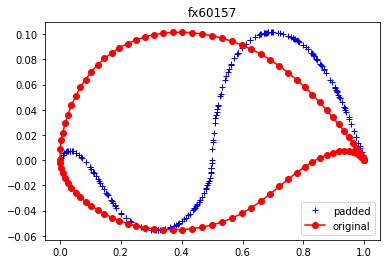

In [14]:
i = 1348
plt.figure()
plt.plot(padded_x1s[i], padded_x2s[i], '+b', label='padded')
plt.plot(x1s[i], x2s[i], '-or', label='original')
plt.title(airfoil_names[i])
plt.legend()
print('first x-coord: ', padded_x1s[i][0])
print('last x-coord: ',padded_x1s[i][-1])

Setting up the input and output data by normalizing both flow parameters, shuffling and splitting up the datasets into training, dev.. and testing sets.

In [30]:
def create_TrainDevTest_sets(RE=Re, ALPHA=alpha, CL_DICT=cl_dict, AIRFOILS=airfoil_names, PADDED_X1S=padded_x1s, PADDED_X2S=padded_x2s):  
  X = []
  Y = []
  Y_NAMES = []

  RE_norm = np.log10(RE)/np.mean(np.log10(RE))
  ALPHA_norm = ALPHA/np.max(np.abs(ALPHA))

  for ii in range(len(PADDED_X1S)):
    for jj in range(RE.shape[0]):
      for kk in range(ALPHA.shape[0]):
        if np.isnan(CL_DICT[AIRFOILS[ii]][jj, kk]) == False:
          # input data
          X.append([RE_norm[jj], ALPHA_norm[kk], CL_DICT[AIRFOILS[ii]][jj, kk]])
          # label data
          Y.append(PADDED_X1S[ii] + PADDED_X2S[ii])
          # names of the airfoils for comparison with the labels
          Y_NAMES.append(AIRFOILS[ii])

  X = np.array(X, dtype=float)
  Y = np.array(Y, dtype=float)
  Y_NAMES = np.array(Y_NAMES, dtype=str)

  # bounds of the lift coefficient CL
  CL_LIMS = [np.min(X[:,2]), np.max(X[:,2])]

  np.random.seed(1)
  shuffle = np.random.permutation(X.shape[0])
  X_shuffled = X[shuffle, :]
  Y_shuffled = Y[shuffle, :]
  Y_NAMES_shuffled = Y_NAMES[shuffle]

  train_size = 0.8
  dev_size = (1 - train_size)*0.5
  test_size = (1 - train_size)*0.5
  test_length = int(test_size*X.shape[0])
  dev_length = int(dev_size*X.shape[0])
  train_length = X.shape[0] - test_length - dev_length

  X_TRAIN = X_shuffled[:train_length, :]
  X_DEV = X_shuffled[train_length:train_length+dev_length, :]
  X_TEST = X_shuffled[train_length+dev_length:, :]

  Y_TRAIN = Y_shuffled[:train_length, :]
  Y_DEV = Y_shuffled[train_length:train_length+dev_length, :]
  Y_TEST = Y_shuffled[train_length+dev_length:, :]

  Y_NAMES_TRAIN = Y_NAMES_shuffled[:train_length]
  Y_NAMES_DEV = Y_NAMES_shuffled[train_length:train_length+dev_length]
  Y_NAMES_TEST = Y_NAMES_shuffled[train_length+dev_length:]

  return CL_LIMS, X_TRAIN, X_DEV, X_TEST, Y_TRAIN, Y_DEV, Y_TEST, Y_NAMES_TRAIN, Y_NAMES_DEV, Y_NAMES_TEST

cl_lims, X_train, X_dev, X_test, Y_train, Y_dev, Y_test, Y_names_train, Y_names_dev, Y_names_test = create_TrainDevTest_sets()

# Re.shape[0] * alpha.shape[0] * len(x1s) = 650,580
# X.shape[0] = 404,234
# --> approximatly 250,000 cls were not computed, less than 2/3 of the dataset can be used

Define functions for bringing the coordinates in the original order and making the input values dimensional again.

In [16]:
def make_dimensional(X_in, RE=Re, ALPHA=alpha):
  X_out = np.zeros((1,3))[0,:]
  X_out[0] = 10**(np.mean(np.log10(RE))*X_in[0])
  X_out[1] = X_in[1]*np.max(np.abs(ALPHA))
  X_out[2] = X_in[2]
  return X_out

def original_order(Y_PREDICT):
  # function that brings the coordinates in the original order and divides the predicted coordinates into x and y vectors
  x_PREDICT = np.array(list(reversed(Y_PREDICT[0, :int(Y_PREDICT.shape[1]*0.5)]*2 - 1)))
  y_PREDICT = np.array(list(reversed(Y_PREDICT[0, int(Y_PREDICT.shape[1]*0.5):])))
  x_upper = x_PREDICT[x_PREDICT>=0]
  x_lower = x_PREDICT[x_PREDICT<0]
  x_lower = -1.*x_lower
  x_PREDICT = np.concatenate((x_upper, x_lower))
  return x_PREDICT, y_PREDICT

Define callback functions for adjusting the learning rate during trainings.

In [24]:
# This function keeps the initial learning rate for the first Z epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  Z = 3
  if epoch < Z:
    return lr
  else:
    return lr * tf.math.exp(-0.3)

# instantiate a callback with a learning rate scheduler, can be used during training
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-20)

# create a custom callback that returns the current learing rate after each epoch
# class CustomCallback(tf.keras.callbacks.Callback):
#  def on_epoch_end(self, epoch, logs=None):
#      print(self.model.optimizer.lr)

# Build the model
A generic model is build to perform a hyperparameter search to get the most promising network architecture.

In [25]:
def create_model(Neurons=[1024, 512], Batch_Norm=False, Dropouts=[0.0, 0.0], Activation=tf.nn.relu, nOutputs=padding_length*2):

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=(3)))
  for ii in range(len(Neurons)):
    model.add(tf.keras.layers.Dense(Neurons[ii], activation=Activation))
    if Batch_Norm == True:
      model.add(tf.keras.layers.BatchNormalization())
    if len(Neurons) == len(Dropouts): # use no drop-outs if the the number of dense layers does not equal the number of drop out layers
      model.add(tf.keras.layers.Dropout(Dropouts[ii]))
  model.add(tf.keras.layers.Dense(nOutputs)) # No activation function required. Do not use relu as it damps out the negative y (x2) values

  model.compile(optimizer = tf.optimizers.Adam(), loss = 'MeanSquaredError', metrics=['accuracy'])
  
  return model

Define the parameters of the random hyperparameter search.

In [26]:
from random import uniform, randint, getrandbits
random.seed(3)

# define the random search parameters

len_arrays = 10 # number of hyperparameter sets to try
batch_size = [randint(32, 1024) for i in range(len_arrays)]
epochs = [randint(20, 50) for i in range(len_arrays)] # use comma for more values ex. [10, 50, 100]
Neurons = []
Dropouts = []
for i in range(len_arrays):
  nLayers = randint(1,5)
  Neurons.append([randint(256, 2048) for i in range(nLayers)])
  Dropouts.append([0.0 for i in range(nLayers)])
  # Dropouts.append([uniform(0.0, 0.3) for i in range(nLayers)])
Batch_Norm = [bool(getrandbits(1)) for i in range(len_arrays)]
num_of_parameters_that_we_want_to_use = 5
param_random_grid = dict(batch_size=batch_size,
                         epochs=epochs,
                         Neurons=Neurons,
                         Batch_Norm=Batch_Norm,
                         Dropouts=Dropouts,
                        )

print(param_random_grid)

{'batch_size': [275, 638, 589, 165, 410, 969, 650, 517, 672, 626], 'epochs': [22, 39, 20, 49, 46, 35, 28, 37, 27, 26], 'Neurons': [[1363, 1969, 1381, 1231], [1564, 2019, 564, 730], [2033, 1327], [1774, 287, 1631, 1847], [582], [343, 872, 1853, 319, 1942], [1224, 1474, 1728], [1718, 1870, 1130, 1064], [1166, 530, 1004, 455, 329], [1269, 700]], 'Batch_Norm': [False, True, True, False, True, True, True, False, False, True], 'Dropouts': [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0]]}


# Run the Hyperparameter Search
One set of parameters per iteration. Unfortunately no parallel jobs, meaning one set after another.

Epoch 1/22
1177/1177 [==============================] - 342s 289ms/step - loss: 0.1197 - accuracy: 0.1867 - val_loss: 0.0359 - val_accuracy: 0.3549
Epoch 2/22
1177/1177 [==============================] - 339s 288ms/step - loss: 0.0347 - accuracy: 0.3579 - val_loss: 0.0711 - val_accuracy: 0.7673
Epoch 3/22
1177/1177 [==============================] - 340s 289ms/step - loss: 0.0217 - accuracy: 0.4570 - val_loss: 3.4093 - val_accuracy: 0.7803
Epoch 4/22
1177/1177 [==============================] - 339s 288ms/step - loss: 0.0172 - accuracy: 0.5464 - val_loss: 2.9107 - val_accuracy: 0.7801
Epoch 5/22
1177/1177 [==============================] - 346s 294ms/step - loss: 0.0150 - accuracy: 0.6154 - val_loss: 7.9300 - val_accuracy: 0.7817
Epoch 6/22
1177/1177 [==============================] - 342s 290ms/step - loss: 0.0140 - accuracy: 0.6766 - val_loss: 4.1149 - val_accuracy: 0.7838
Epoch 7/22
1177/1177 [==============================] - 335s 285ms/step - loss: 0.0137 - accuracy: 0.7226 - val_

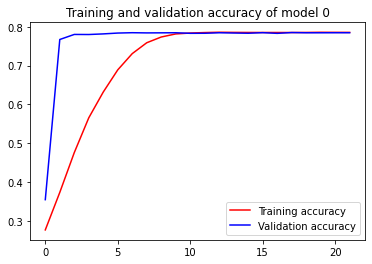

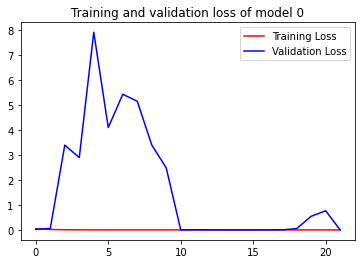

Epoch 1/39
508/508 [==============================] - 256s 502ms/step - loss: 0.0353 - accuracy: 0.3565 - val_loss: 0.0148 - val_accuracy: 0.7858
Epoch 2/39
508/508 [==============================] - 254s 501ms/step - loss: 0.0145 - accuracy: 0.5380 - val_loss: 0.0141 - val_accuracy: 0.7858
Epoch 3/39
508/508 [==============================] - 257s 505ms/step - loss: 0.0140 - accuracy: 0.5844 - val_loss: 0.0135 - val_accuracy: 0.7857
Epoch 4/39
508/508 [==============================] - 258s 509ms/step - loss: 0.0137 - accuracy: 0.6136 - val_loss: 0.0134 - val_accuracy: 0.7858
Epoch 5/39
508/508 [==============================] - 257s 506ms/step - loss: 0.0136 - accuracy: 0.6399 - val_loss: 0.0135 - val_accuracy: 0.7842
Epoch 6/39
508/508 [==============================] - 258s 508ms/step - loss: 0.0135 - accuracy: 0.6571 - val_loss: 0.0134 - val_accuracy: 0.7761
Epoch 7/39
508/508 [==============================] - 262s 515ms/step - loss: 0.0135 - accuracy: 0.6712 - val_loss: 0.0136 -

In [ ]:
history = []
for ii in range(len_arrays):
  random_model = create_model(Neurons=Neurons[ii], Batch_Norm=Batch_Norm[ii], Dropouts=Dropouts[ii], Activation=tf.nn.relu, nOutputs=padding_length*2)

  history.append(random_model.fit(X_train,
                                  Y_train,
                                  batch_size=batch_size[ii],
                                  epochs=epochs[ii],
                                  verbose=1,
                                  validation_data=(X_dev, Y_dev)
                                 )
                )
  
  acc = history[ii].history['accuracy']
  val_acc = history[ii].history['val_accuracy']
  loss = history[ii].history['loss']
  val_loss = history[ii].history['val_loss']

  epochs_plot = range(len(acc))

  plt.plot(epochs_plot, acc, 'r', label='Training accuracy')
  plt.plot(epochs_plot, val_acc, 'b', label='Validation accuracy')
  plt.title(f'Training and validation accuracy of model {ii}')
  plt.legend()
  plt.figure()

  plt.plot(epochs_plot, loss, 'r', label='Training Loss')
  plt.plot(epochs_plot, val_loss, 'b', label='Validation Loss')
  plt.title(f'Training and validation loss of model {ii}')
  plt.legend()

  plt.show()

# Oldschool Training
A shallow model performs almost as good as one found through the hyperparameter search.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 410)               420250    
Total params: 424,346
Trainable params: 424,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1264/1264 [==============================] - 31s 24ms/step - loss: 0.0074 - accuracy: 0.5864 - val_loss: 3.8089e-04 - val_accuracy: 0.7929
Epoch 2/20
1264/1264 [==============================] - 28s 22ms/step - loss: 3.8220e-04 - accuracy: 0.7958 - val_loss: 3.7893e-04 - val_accuracy: 0.8005
Epoch 3/20
1264/1264 [==============================] - 28s 22ms/step - loss: 3.7952e-04 - accuracy: 0.7989 - val_loss: 3.9469e-04 - val_accuracy: 0.8005
Epoch 4/20
1264/1264 [==============================] 

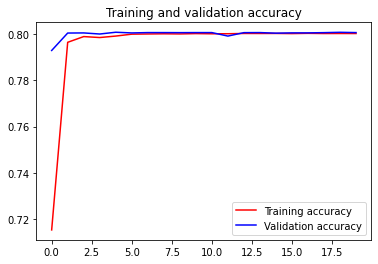

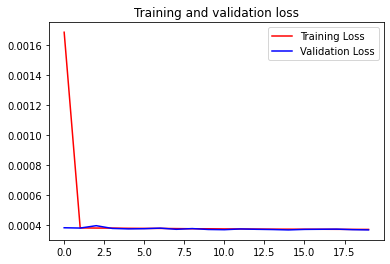

In [27]:
model0 = create_model(Neurons=[1024]) # arguments define the architecture
model0.summary()

history = model0.fit(X_train, Y_train, batch_size=256, epochs=20, verbose=1, validation_data=(X_dev, Y_dev))#, callbacks=[reduce_lr])#, callbacks=[callback])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_plot = range(len(acc))

plt.plot(epochs_plot, acc, 'r', label='Training accuracy')
plt.plot(epochs_plot, val_acc, 'b', label='Validation accuracy')
plt.title(f'Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_plot, loss, 'r', label='Training Loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation Loss')
plt.title(f'Training and validation loss')
plt.legend()

plt.show()

# Performance on the Test Set

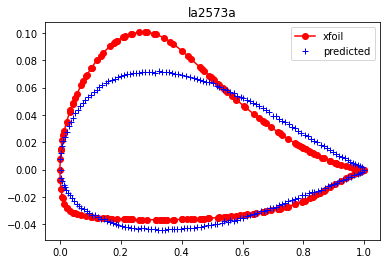

In [28]:
# model0.evaluate(X_test, Y_test)
i = 150 # index of the example from the test set
Y_predict = model0.predict(X_test[i,:].reshape((1,3)))
x1_test, x2_test = original_order(Y_test[i,:].reshape((1,Y_test.shape[1])))
x1_predict, x2_predict = original_order(Y_predict)
plt.figure()
plt.plot(x1_test, x2_test, '-or', label='xfoil')
plt.plot(x1_predict, x2_predict, '+b', label='predicted')
plt.title(Y_names_test[i])
plt.legend()

# Test Custom Inputs
Be aware of the bounds to the input values. Offers a validation with XFoil.

Input values (Re, alpha, cl): [8.49332196e+06 5.00000000e+00 6.42650425e-01]


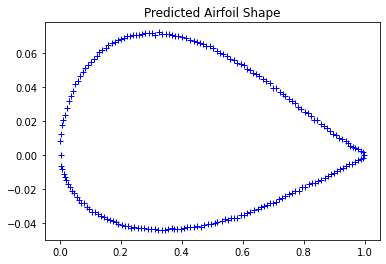

Input lift coefficient: 0.6426504254341125
Lift coefficient computed with XFoil from predicted airfoil shape: nan


In [32]:
def custom_predict(X_TEST, MODEL=model0, RE=Re, ALPHA=alpha, CL_LIMS=cl_lims):
  if (X_TEST[0] > np.max(RE)) or (X_TEST[0] < np.min(RE)):
    print(f'Reynolds number must be between {np.min(RE)} and {np.max(RE)}')
    return None, None, None
  if (X_TEST[1] > np.max(ALPHA)) or (X_TEST[1] < np.min(ALPHA)):
    print(f'Angle of attack must be between {np.min(ALPHA)} and {np.max(ALPHA)}')
    return None, None, None
  if (X_TEST[2] > CL_LIMS[1]) or (X_TEST[2] < CL_LIMS[0]):
    print(f'Lift coefficient must be between {CL_LIMS[0]} and {CL_LIMS[1]}')
    return None, None, None
    
  
  X_TEMP = np.zeros((1,3))

  X_TEMP[0, 0] = np.log10(X_TEST[0])/np.mean(np.log10(RE))
  X_TEMP[0, 1] = X_TEST[1]/5.
  X_TEMP[0, 2] = X_TEST[2]

  Y_PREDICT = MODEL.predict(X_TEMP)
  x_PREDICT, y_PREDICT = original_order(Y_PREDICT)
  
  print(f'Input values (Re, alpha, cl): {X_TEST}')

  plt.figure()
  plt.plot(x_PREDICT, y_PREDICT, '+b')
  plt.title('Predicted Airfoil Shape')
  plt.show()

  xf = XFoil()
  xf.max_iter = 100 # maximum number of iterations used for try computing the coefficients
  xf.airfoil = Airfoil(x_PREDICT, y_PREDICT) # determin the airfoil shape from coordinates in accordance with XFoil
  xf.Re = X_TEST[0]
  CL_XFOIL, CD_XFOIL, CM_XFOIL, something = xf.a(X_TEST[1])

  print(f'Input lift coefficient: {X_TEST[2]}')
  print(f'Lift coefficient computed with XFoil from predicted airfoil shape: {CL_XFOIL}')

  return x_PREDICT, y_PREDICT, CL_XFOIL

# X_custom = [[Reynolds number, angle of attack, desired lift coefficient]]
# Reynolds number between 1,400,000 and 10,500,000
# angle of attack between -5,0 and 5,0
# lift coefficient between -0.8 and 2.1
#X_custom = np.array([5.0e6, 1., 1.5])
i = 150 # index of the example from the test set
X_custom = make_dimensional(X_test[i,:])
x_coord_custom, y_coord_custom, cl_XFoil = custom_predict(X_custom)

# Outlook
- trying a smaller range of Reynolds number
- building an API to the original XFoil tool to assure quality of computations
- finding better solver parameters to improve the stability of XFoil
- validate the predictions with XFoil